# PyTorch 循环神经网络（RNN）
循环神经网络是一类神经网络架构，专门用于处理序列数据。它们在自然语言处理、时间序列预测和其他需要考虑上下文的任务中非常有效。PyTorch 提供了强大的工具来构建和训练 RNN 模型。

RNN的关键特性是其能够保持隐状态（hidden state），使得网络能够记住之前的信息。RNN 的基本单元是一个循环单元，它在每个时间步上接收输入并更新隐状态。

## RNN得基本结构
在传统的前馈神经网络中，信息只在一个方向上流动，而在 RNN 中，数据不仅沿着网络层及流动，还会在每个时间步骤上传播到当前的隐层状态，从而将之前的信息传递到下一个时间步骤。

隐状态：RNN是通过隐状态来记住序列中的信息。隐状态是通过上一时间步得隐状态和当前输入共同计算得到的，
$$
h_t = f(W_{hh}\cdot h_{t-1} + W_{hx}\cdot x_t + b_h)
$$
其中，$h_t$ 是当前时间步的隐状态，$h_{t-1}$ 是上一时间步的隐状态，$x_t$ 是当前输入，$W_{hh}$ 和 $W_{hx}$ 是权重矩阵，$b_h$ 是偏置项，$f$ 是激活函数（通常是 tanh 或 ReLU）。

输出：RNN的输出不仅依赖于当前的输入，还依赖于隐状态的历史信息，
$$
y_t = g(W_{hy}\cdot h_t + b_y)
$$
其中，$y_t$ 是当前时间步的输出，$W_{hy}$ 是隐状态到输出的权重矩阵，$b_y$ 是偏置项，$g$ 是激活函数（通常是 softmax 或 sigmoid）。

## RNN 如何处理序列数据
RNN在处理序列数据时的展开视图如下：

![RNN strcture](<assets/ch_RNN.png>)

RNN是一种处理序列数据的神经网络，它通过循环连接来处理序列中的每个元素，并在每个时间步传递信息，以下是图中各个部分的说明：
- 输入序列`Xt, Xt-1, Xt+1, ...`：图中的粉色圆圈代表输入序列中的元素，如 `Xt` 表示当前时间步的输入，`Xt-1` 表示前一个时间步的输入，依此类推；
- 隐状态`ht, ht-1, ht+1, ...`：图中的绿色矩形代表隐状态，它在每个时间步存储有关序列的信息，`ht` 表示当前时间步的隐状态，`ht-1` 表示前一个时间步的隐状态，依此类推；
- 权重矩阵`(U, W, V)`：图中的箭头代表 RNN 的权重矩阵，它们分别连接输入、隐状态和输出，即分别是
  - `U`：输入到隐状态的权重矩阵，用于将输入`Xt`转换为隐状态的一部分；
  - `W`：隐状态到隐状态的权重矩阵，用于将前一时间步的隐状态`ht-1`转换为当前时间步隐状态的一部分；
  - `V`：隐状态到输出的权重矩阵，用于将当前时间步的隐状态`ht`转换为输出的一部分；
- 输出序列`Yt, Yt-1, Yt+1, ...`：图中的蓝色圆圈代表输出序列中的元素，如 `Yt` 表示当前时间步的输出，`Yt-1` 表示前一个时间步的输出，依此类推；
- 循环连接：RNN的特点是隐状态的循环连接，这允许网络在处理当前时间步的输入时考虑到之前时间步的信息；
- 展开（Unfold）：图中展示了RNN在序列上的展开视图，可以方便理解RNN在每个时间步上都有一个隐状态和输出，这些隐状态和输出通过循环连接形成一个链式结构；但是在实际的RNN实现中，这些步骤是并行处理的，但在概念上可以将其视为一个展开的序列；
- 信息流动：信息从输入序列通过权重矩阵`U`传递到隐状态，然后通过权重矩阵`W`在时间步之间传递，最后通过权重矩阵`V`从隐藏状态传递到输出序列；

## PyTorch 实现 RNN
在 PyTorch 中，可以使用 `torch.nn.RNN` 类来实现 RNN。以下是一个简单的示例，演示如何创建和训练一个 RNN 模型。

步骤：
1. 导入必要的库
2. 定义 RNN 模型
3. 创建训练数据
4. 定义损失函数和优化器
5. 训练模型
6. 评估模型

In [19]:
# 1. import the necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [20]:
# 2. define the RNN model
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        # define the RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        # define the fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    # define the forward pass
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        # out shape: (batch_size, seq_length, hidden_size)
        out, _ = self.rnn(x)
        # get the last time step output
        out = self.fc(out[:, -1, :])  # (batch_size, output_size)
        # out = self.fc(out)           # fully connected layer
        return out

In [21]:
# 3. generate some random data
num_samples = 1000
seq_length = 10
input_size = 5
output_size = 2          # assuming binary classification

# generate input data randomly (batch_size, seq_length, input_size)
X = torch.randn(num_samples, seq_length, input_size)#.astype(np.float32)
# generate target data randomly (batch_size, output_size)
Y = torch.randint(0, output_size, (num_samples,))#.astype(np.float32)

# create the dataset and dataloader
dataset = TensorDataset(X, Y)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [22]:
# 4. instantiate the model, loss function, and optimizer
model = SimpleRNN(input_size=input_size, hidden_size=64, output_size=output_size)
criterion = nn.CrossEntropyLoss()  # assuming binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [23]:
# 5. train the model
num_epochs = 10

for epoch in range(num_epochs):
    model.train()  # set the model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        # forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {accuracy:.2f}%')

Epoch [1/10], Loss: 0.6999, Accuracy: 48.40%
Epoch [2/10], Loss: 0.6924, Accuracy: 53.40%
Epoch [3/10], Loss: 0.6899, Accuracy: 53.90%
Epoch [4/10], Loss: 0.6841, Accuracy: 53.80%
Epoch [5/10], Loss: 0.6781, Accuracy: 58.20%
Epoch [6/10], Loss: 0.6768, Accuracy: 58.90%
Epoch [7/10], Loss: 0.6730, Accuracy: 58.40%
Epoch [8/10], Loss: 0.6760, Accuracy: 57.60%
Epoch [9/10], Loss: 0.6716, Accuracy: 59.10%
Epoch [10/10], Loss: 0.6681, Accuracy: 58.40%


In [24]:
# 6. test the model
model.eval()  # set the model to evaluation mode
with torch.no_grad():
    total = 0
    correct = 0
    for inputs, labels in train_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

Test Accuracy: 59.30%


# The Complete Code

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# datasets: predict the charater sequence
char_set = list("hello")
char_to_index = {c: i for i, c in enumerate(char_set)}
index_to_char = {i: c for i, c in enumerate(char_set)}

# dataset prepare
input_str = "hello"
target_str = "elloh"
input_data = [char_to_index[c] for c in input_str]
target_data = [char_to_index[c] for c in target_str]

# convert to single-hot encoding
input_one_hot = np.eye(len(char_set))[input_data]

# convert to tensor
inputs = torch.tensor(input_one_hot, dtype=torch.float32)  # (1, seq_length, input_size)
targets = torch.tensor(target_data, dtype=torch.long)  # (1, seq_length)

# the super-parameters of the model
input_size = len(char_set)  # number of unique characters
hidden_size = 8   # number of hidden units
output_size = len(char_set)  # number of unique characters
num_epochs = 200
learning_rate = 0.1

# define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden
    
# instantiate the model, loss function, and optimizer
model = RNNModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# train the model
losses = []
hidden = None   # initial hidden state, set to None
for epoch in range(num_epochs):
    optimizer.zero_grad()  # zero the gradients

    # forward pass
    outputs, hidden = model(inputs.unsqueeze(0), hidden)  # add batch dimension
    hidden = hidden.detach()  # detach the hidden state to prevent backpropagation through time

    # calculate loss
    loss = criterion(outputs.view(-1, output_size), targets)
    loss.backward()
    optimizer.step()  # update the weights
    losses.append(loss.item())  # append the loss to the list

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


# test RNN
with torch.no_grad():
    test_hidden = None
    test_output, _ = model(inputs.unsqueeze(0), test_hidden)
    predicted = torch.argmax(test_output, dim=2).squeeze(0).numpy()  # remove the batch dimension

    print("input squence: ", "".join([index_to_char[i] for i in input_data]))
    print("predicted squence: ", "".join([index_to_char[i] for i in predicted]))



Epoch [20/200], Loss: 0.0014
Epoch [40/200], Loss: 0.0004
Epoch [60/200], Loss: 0.0002
Epoch [80/200], Loss: 0.0002
Epoch [100/200], Loss: 0.0002
Epoch [120/200], Loss: 0.0001
Epoch [140/200], Loss: 0.0001
Epoch [160/200], Loss: 0.0001
Epoch [180/200], Loss: 0.0001
Epoch [200/200], Loss: 0.0001
input squence:  hello
predicted squence:  elloh


# 代码解析：
- 数据准备：
    1. 使用字符序列hello，并将其转化为独热编码
    2. 目标序列为elloh， 即享有旋转一个字符的效果
- 模型构建
    1. 使用torch.nn.RNN构建RNN模型
    2. 加入全连接层 torch.nn.Linear 用于映射隐藏状态到输出
- 训练部分：
    1. 每一轮都计算损失并反向传播
    2. 隐藏状态通过hidden.detach()来防止梯度爆炸
- 测试部分
    1. 模型输出字符的预测结果
- 可视化
    - 使用matplotlib可视化训练损失

Epoch [20/200], Loss: 0.0013
Epoch [40/200], Loss: 0.0003
Epoch [60/200], Loss: 0.0002
Epoch [80/200], Loss: 0.0002
Epoch [100/200], Loss: 0.0001
Epoch [120/200], Loss: 0.0001
Epoch [140/200], Loss: 0.0001
Epoch [160/200], Loss: 0.0001
Epoch [180/200], Loss: 0.0001
Epoch [200/200], Loss: 0.0001
input sequence:  hello
predicted sequence:  elloh


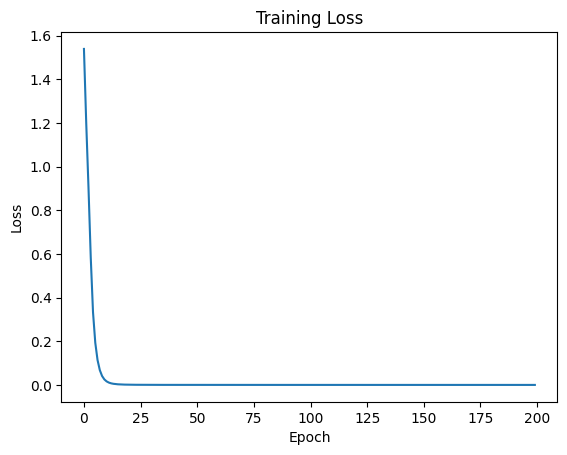

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# datasets: predict the charater sequence
char_set = list("hello")
char_to_index = {c: i for i, c in enumerate(char_set)}
index_to_char = {i: c for i, c in enumerate(char_set)}

# dataset prepare
input_str = "hello"
target_str = "elloh"
input_data = [char_to_index[c] for c in input_str]
target_data = [char_to_index[c] for c in target_str]

# convert to single-hot encoding
input_one_hot = np.eye(len(char_set))[input_data]

# convert to tensor
inputs = torch.tensor(input_one_hot, dtype=torch.float32)  # (seq_length, input_size)
targets = torch.tensor(target_data, dtype=torch.long)  # (seq_length)

# the super-parameters of the model
input_size = len(char_set)  # number of unique characters
hidden_size = 8   # number of hidden units
output_size = len(char_set)  # number of unique characters
num_epochs = 200
learning_rate = 0.1

# define the RNN model
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.hidden_size = hidden_size

    def forward(self, x, hidden=None):
        # Initialize hidden state if not provided
        if hidden is None:
            batch_size = x.size(0)
            hidden = torch.zeros(1, batch_size, self.hidden_size)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden
    
# instantiate the model, loss function, and optimizer
model = RNNModel(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# train the model
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()  # zero the gradients

    # forward pass
    outputs, hidden = model(inputs.unsqueeze(0))  # add batch dimension
    hidden = hidden.detach()  # detach the hidden state to prevent backpropagation through time

    # calculate loss
    loss = criterion(outputs.view(-1, output_size), targets)
    
    # backward pass and optimize
    loss.backward()
    optimizer.step()
    
    # append the loss to the list
    losses.append(loss.item())

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


# test RNN
with torch.no_grad():
    test_output, _ = model(inputs.unsqueeze(0))
    predicted = torch.argmax(test_output, dim=2).squeeze(0).numpy()  # remove the batch dimension

    print("input sequence: ", "".join([index_to_char[i] for i in input_data]))
    print("predicted sequence: ", "".join([index_to_char[i] for i in predicted]))

# plot the loss
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()